# APAN 5440 FINAL PROJECT 
## Financial Data Science Optimization

#### Zian Gong, Jiaran Yu, Shuyang Li, Minjian Hu, Kexin Lian

### Checkpoint 1

In [98]:
#import library
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols 
from scipy.stats import gaussian_kde 
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
from patsy import dmatrix
from tqdm import tqdm

In [99]:
#read files
model_dir = 'C:\\Users\\Jiara\\OneDrive\\Desktop\\ml in fin\\APANPS5440\\APANPS5440\\'

def sort_cols(test):
  return (test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2008,2009,2010]:
  fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2" 
  frames.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames:
  frames[x] = sort_cols(frames[x])

covariance = {}
for year in [2007,2008,2009,2010]:
  fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
  covariance.update(pickle.load( bz2.open(fil, "rb" ) ))

In [100]:
#change column name from "1DREVRSL" to "DREVRSL" because invalid syntax
for date in frames:
    frames[date] = frames[date].rename(columns={"1DREVRSL": "DREVRSL"})

In [101]:
#wins. set lower and upper bounds
def wins(x,a,b):
  return (np.where(x <= a,a, np.where(x >= b, b, x)))

In [102]:
#leaving alone any columns which contain string or other date types.
def clean_nas(df):
  numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
  
  for numeric_column in numeric_columns:
    df[numeric_column] = np.nan_to_num(df[numeric_column])
  return df

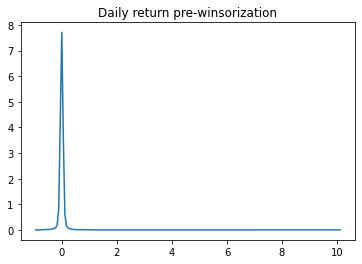

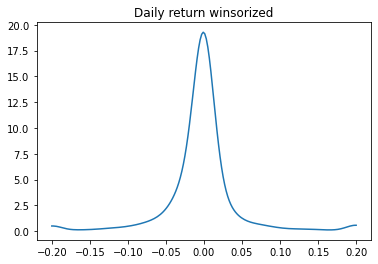

In [103]:
#using density plots to see whether win function works
def density_plot(data, title):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data), 200) 
    density.covariance_factor = lambda : .25 
    density._compute_covariance() 
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()

test = frames['20080808']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'], -0.2, 0.2), 'Daily return winsorized')

### checkpoint2

In [104]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(n)

#it takes as input the data frame corresponding to the model data for one particular day
#and outputs the factor returns

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    ## remove NA prevent error
    estu=estu.fillna(0)

    ## winsorize returns for fitting 
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "Ret")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [105]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

<AxesSubplot:>

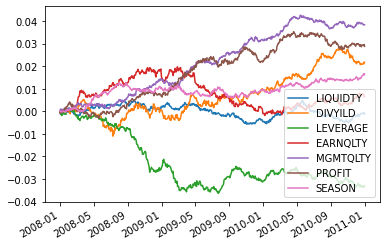

In [106]:
# collect coefficients into a new data frame called facret_df
# plot the cumulative summations of factor returns for selected alpha factors

alpha_factors = ['LIQUIDTY','DIVYILD','LEVERAGE','EARNQLTY','MGMTQLTY','PROFIT','SEASON']
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))
facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

facret_df.cumsum().plot()

### Checkpoint3

In [107]:
#P1
## include a column to hold the portfolio weights of the previous day
## initialized to zero weights when the backtest first starts

previous_holdings = pd.DataFrame(data = {"ID" : ["ID1000"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]
df = clean_nas(df.merge(previous_holdings, how = 'left', on = 'ID'))
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

In [108]:
#P2 build universe based on filters
def build_universe(df):
    universe = df.loc[(df['IssuerMarketCap'] >= 1e9) | (abs(df['h.opt.previous']) > 0)].copy()
    universe = universe.drop(columns = 'Ret')
    return universe

universe = build_universe(df)

In [109]:
date = str(int(universe['DataDate'][1])) 

In [110]:
#P3
# Industry factors are sometimes defined as one-hot encodings for which industry a stock lives in
# hence they sum to an intercept and with the collection of industry factors included
# In this data set, we allow a stock to be split between 2 or 3 industries, but still the loadings sum to 1. 

industries = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',

       'BANKS', 'BEVTOB', 'BIOLIFE', 'BLDGPROD', 'CHEM', 'CNSTENG',

       'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC', 'COMSVCS', 'CONGLOM',

       'CONTAINR', 'DISTRIB', 'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',

        'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR', 'INDMACH',

        'INSURNCE', 'INTERNET', 'LEISPROD', 'LEISSVCS', 

       'LIFEINS', 'MEDIA', 'MGDHLTH', 'MULTUTIL', 'OILGSCON', 'OILGSDRL', 'OILGSEQP',

       'OILGSEXP', 'PAPER', 'PHARMA', 'PRECMTLS', 

       'PSNLPROD', 'REALEST', 'RESTAUR', 'ROADRAIL', 

       'SEMICOND', 'SEMIEQP', 'SOFTWARE', 'SPLTYRET',

       'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT','WIRELESS']

# Separately, a set of "style factors" which are continuous, real-valued predictors. 

styles = ['BETA', 'DIVYILD', 'DWNRISK', 'EARNQLTY', 'EARNYILD', 'GROWTH', 

       'INDMOM', 'LEVERAGE', 'LIQUIDTY', 'LTREVRSL', 'MGMTQLTY',

       'MIDCAP', 'MOMENTUM', 'PROFIT', 'PROSPECT', 'RESVOL', 'SEASON','SENTMT', 'SIZE','STREVRSL','VALUE' ]

all_factors = industries + styles

# set of non-alpha factors are risk factors
def setdiff(all_factors, alpha_factors): 
    risk_factors = [x for x in all_factors if x not in set(alpha_factors)]
    return risk_factors

risk_factors = setdiff(all_factors, alpha_factors)

h0= universe['h.opt.previous']

In [111]:
#p4 direct analogue of the model.matrix function in R
form = '0 + ' + ' + '.join(styles) + ' + ' + ' + '.join(industries)

In [112]:
def model_matrix(formula,data):
    return dmatrix(form,data)

In [113]:
## matrix of risk factor exposures
B = model_matrix(form,universe)

BT = B.transpose()

In [114]:
B

DesignMatrix with shape (2800, 80)
  Columns:
    ['BETA',
     'DIVYILD',
     'DWNRISK',
     'EARNQLTY',
     'EARNYILD',
     'GROWTH',
     'INDMOM',
     'LEVERAGE',
     'LIQUIDTY',
     'LTREVRSL',
     'MGMTQLTY',
     'MIDCAP',
     'MOMENTUM',
     'PROFIT',
     'PROSPECT',
     'RESVOL',
     'SEASON',
     'SENTMT',
     'SIZE',
     'STREVRSL',
     'VALUE',
     'AERODEF',
     'AIRLINES',
     'ALUMSTEL',
     'APPAREL',
     'AUTO',
     'BANKS',
     'BEVTOB',
     'BIOLIFE',
     'BLDGPROD',
     'CHEM',
     'CNSTENG',
     'CNSTMACH',
     'CNSTMATL',
     'COMMEQP',
     'COMPELEC',
     'COMSVCS',
     'CONGLOM',
     'CONTAINR',
     'DISTRIB',
     'DIVFIN',
     'ELECEQP',
     'ELECUTIL',
     'FOODPROD',
     'FOODRET',
     'GASUTIL',
     'HLTHEQP',
     'HLTHSVCS',
     'HOMEBLDG',
     'HOUSEDUR',
     'INDMACH',
     'INSURNCE',
     'INTERNET',
     'LEISPROD',
     'LEISSVCS',
     'LIFEINS',
     'MEDIA',
     'MGDHLTH',
     'MULTUTIL',
     'OILGS

In [115]:
#P5 specific variance for each stock in the universe
specVar = (0.01 * universe['SpecRisk']) ** 2

In [116]:
covariance['20080102'].head()

,Factor1,Factor2,VarCovar,DataDate
0,1DREVRSL,1DREVRSL,6.137143,20080102
1,1DREVRSL,BETA,-0.876592,20080102
2,1DREVRSL,DIVYILD,-0.256477,20080102
3,1DREVRSL,DWNRISK,0.359316,20080102
4,1DREVRSL,EARNQLTY,-0.141918,20080102


In [117]:
#P6 factor covariance matrix
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None


In [118]:
#input covariance data, output a matrix containing only the diagonal

def diagonal_factor_cov(date, B):
    cv = covariance[date]
    k = np.shape(B)[1]
    Fm = np.zeros([k,k])
    
    for j in range(0,k):
        factor = colnames(B)[j]
        # rescale
        Fm[j,j]=(0.01**2)*cv.loc[(cv.Factor1 == factor)&(cv.Factor2 == factor),'VarCovar'].iloc[0]
    return Fm #factor covariance matrix


In [119]:
Fvar = diagonal_factor_cov(date,B)

In [120]:
#P7 find the relationship between average daily volume fraction and price impact
def get_lambda(universe, compositevolume = 'CompositeVolume'):
    universe.loc[np.isnan(universe[compositevolume]), compositevolume] = 1.0e4
    universe.loc[universe[compositevolume] == 0, compositevolume] = 1.0e4 

    adv = universe[compositevolume]

    return 0.1 / adv

Lambda = get_lambda(universe)

# including initial holdings, optimied holdings, and lambda to get total transaction costs
def get_total_transaction_costs(h0, h_star, Lambda):
    return np.dot((h_star-h0)**2, Lambda)

In [121]:
#P8
# using equal-weighted average of chosen alphas to combine alphas
def rowSums(m):

    return(np.sum(m, axis=1)) 

X_alpha = model_matrix(get_formula(alpha_factors, "SpecRisk"),universe)
alpha_vec = 1e-4 * rowSums(X_alpha)
# The combines alpha vector is supposed to be indicative of the component of future aseet returns
# that is not explained by common factors

risk_aversion = 1.0e-6 
Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

We want to maximize the objective, or equivalently minimize the negative of the objective. 
The negative of the objective function is:
factor risk + idiosyncratic risk - expected portfolio return + transaction costs.

In [122]:
#P9
risk_aversion = 1.0e-6 

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()
 
def func(h):

    tmp = 0.0

    tmp += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )

    tmp += 0.5 * risk_aversion * np.dot(h ** 2, specVar)

    tmp -= np.dot(h, alpha_vec)
    tmp += np.dot( (h - h0) ** 2, Lambda) 
    return(tmp)

Limited-memory BFGS (L-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. Whenever the gradient can be calculated analytically and provided to the optimizer, this should be done as it usually improves performance.

In [123]:
def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda): 

    def func(h): 

        tmp = 0.0
        tmp += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 ) 
        tmp += 0.5 * risk_aversion * np.dot(h ** 2, specVar) 

        #since Specific Variance is diagonal, don't have to do matmul

        tmp -= np.dot(h, alpha_vec)
        tmp += np.dot( (h - h0) ** 2, Lambda)
        return(tmp) 

    def grad(h):
        g = risk_aversion * (h * specVar + np.matmul(QT, np.matmul(Q, h))) - alpha_vec + 2 * Lambda * (h-h0) 

        return(np.asarray(g)) 

    optimizer_result = scipy.optimize.fmin_l_bfgs_b(func, np.asarray(h0), fprime=grad)
    return optimizer_result[0] 

In [124]:
h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
opt_portfolio = pd.DataFrame(data = {"ID" : universe['ID'], "h.opt" : h_star})

In [125]:
def get_portfolio_alpha_exposure(X_alpha, h_star):
     return pd.Series(np.matmul(X_alpha.transpose(), h_star), index=colnames(X_alpha))

portfolio_alpha_exposure = get_portfolio_alpha_exposure(X_alpha, h_star)

def get_risk_exposures(B, BT, h_star):
    risk_exposures = np.matmul(BT, h_star)
    return pd.Series(risk_exposures, index=colnames(B))

risk_exposures = get_risk_exposures(B, BT, h_star)


In [126]:
#P10 put all together 

def form_optimal_portfolio(df, previous, risk_aversion):
    df = clean_nas(df.merge(previous_holdings, how = 'left', on = 'ID'))
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = build_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = industries + styles
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(form,universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    X_alpha = model_matrix(get_formula(alpha_factors, "SpecRisk"),universe)
    alpha_vec = 1e-4 * rowSums(X_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"ID" : universe['ID'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(X_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

### checkpoint4

In [127]:
#P1 build tradelist
# input previous holdings and results of optimization function
# output a tradelist

def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'ID')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

In [128]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev


In [129]:
#P2 walk through each day, calculating the optimal portfolio weights and trade list

trades = {}
port = {}

for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio: 100%|█████████████████████████████████████████████████████████| 757/757 [34:25<00:00,  2.73s/day]


In [130]:
#P3 plots the cumulative sum of the idiosyncratic contribution and risk factor contributions over time
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

# APT model allow us to attribute not only risk but also P&L
# one period P&L is given by idiosyncratic plus factor contributions
def build_pnl_attribution(): 

    df = pd.DataFrame(index = my_dates)

    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]

        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "ID")

        mf['Ret'] = wins(mf['Ret'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['Ret'])
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(fr, p['alpha.exposures'])
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(fr, p['risk.exposures'])
        df.at[dt,"attribution.cost"] = p['total.cost']

    return df

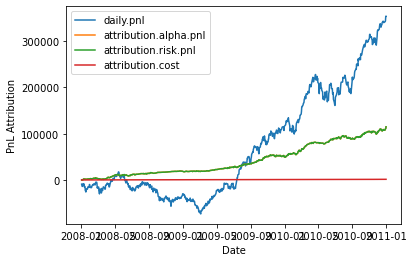

In [131]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [132]:
#P4 calculate the sum of long positions, short positions, net positions, gross market value, 
# and amount of dollars traded

def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = my_dates)

    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']

        df.at[dt,"long"] = np.sum(h[h>0])
        df.at[dt,"short"] = np.sum(h[h<0])
        df.at[dt,"net"] = np.sum(h)
        df.at[dt,"gmv"] = np.sum(np.abs(h))
        df.at[dt,"traded"] = np.sum(np.abs(tradelist['h.opt']-tradelist['h.opt.previous']))

    return df

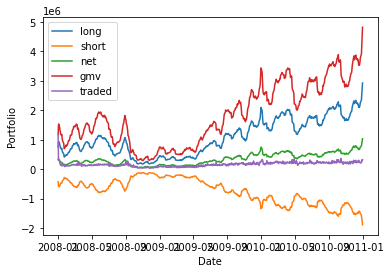

In [133]:
portchar = build_portfolio_characteristics()

for column in portchar.columns:
        plt.plot(portchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()
# the strategy is approximately equal amounts long and short, and net exposure is very low
# self-financing